/home/deadpool/.local/lib/python3.6/site-packages/ipykernel_launcher.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


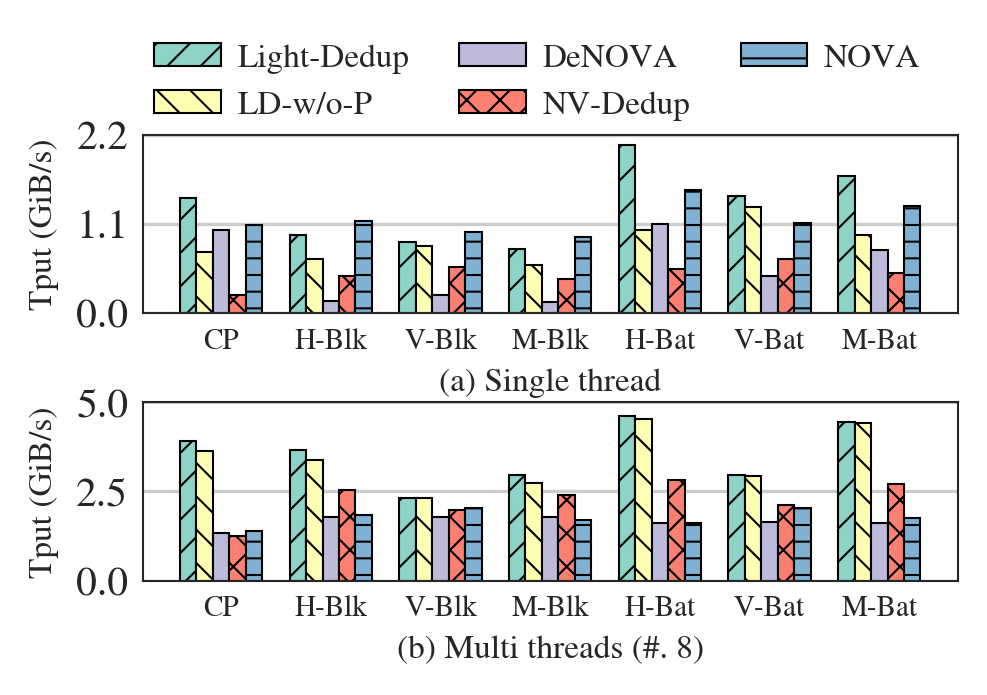

In [7]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linewidth"] = 0.8
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table-cp", "r") as f:
    df_cp = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

with open("./performance-comparison-table-trace", "r") as f:
    df_trace = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

df_cp_low = df_cp[df_cp['num_job'] == 1].drop(columns=['num_job'])
df_cp_mid = df_cp[df_cp['num_job'] == 8].drop(columns=['num_job'])
df_cp_high = df_cp[df_cp['num_job'] == 16].drop(columns=['num_job'])
df_trace_low = df_trace[df_trace['job'] == 1].drop(columns=['job'])
df_trace_mid = df_trace[df_trace['job'] == 8].drop(columns=['job'])
df_trace_high = df_trace[df_trace['job'] == 16].drop(columns=['job'])

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(5)))
gs1 = gridspec.GridSpec(2, 1)
gs1.update(hspace=0.5) # set the spacing between axes.

bar_width = 0.15
# subfig_titles = ["(a) 0% dup ratio", "(b) 25% dup ratio", "(c) 50% dup ratio", "(d) 75% dup ratio"]
subfig_titles = ["(a) Single thread", "(b) Multi threads (#. 8)", "(c) High concurrency"]
patterns = ['///', '\\\\\\', '', 'XXX', '---']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = ["#FFE8B2", "#82EACF", "#88C4D8", "#FFBFBF", "#F3F3F3"]

# dfs = [df_dup0, df_dup25, df_dup50, df_dup75]
# dfs = [df_cp_low, df_cp_mid, df_cp_high, df_trace_low, df_trace_mid, df_trace_high]
fss = df_cp['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']

def bulid_df(dfs, cols):
    df = pd.DataFrame()
    for i in range(len(dfs)):
        cur_df = dfs[i]
        # use file system column and bandwidth column only
        cur_df = cur_df[cols[i]]
        # rename the columns as file_system and bandwidth(MiB/s)
        cur_df.columns = ['file_system', 'bandwidth(MiB/s)']
        # append current df to the final df
        df = pd.concat([df, cur_df])
    return df

def subfig_plot(df, subfig_titles, i):
    subfig = plt.subplot(gs1[i])
    x = [1, 2, 3, 4, 5, 6, 7]
    tot = len(fss) * bar_width
    max_value_int = 0
    for idx, fs in enumerate(fss):
        points = []
        for pivot in x:
            point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
            points.append(point)
        plt.bar(points, df[df['file_system'] == fs]['bandwidth(MiB/s)'] / 1024, width=bar_width, hatch=patterns[idx], edgecolor='black', color=plt.get_cmap('Set3')(idx), linewidth=0.5)
        max_value = (df[df['file_system'] == fs]['bandwidth(MiB/s)'] / 1024).max()
        import math
        if math.ceil(max_value) > max_value_int:
            max_value_int = math.ceil(max_value)
    if i == 0:
        plt.yticks([0, 2.2 / 2, 2.2])
    else:
        plt.yticks([0, max_value_int / 2, max_value_int])

    plt.ylabel('Tput (GiB/s)', fontsize=8)
    plt.xticks(ticks=[1, 2 ,3 ,4 ,5 ,6 ,7], labels=["CP", "H-Blk", "V-Blk", "M-Blk", "H-Bat", "V-Bat", "M-Bat"], rotation=0, fontsize=7)
    plt.xlabel(subfig_titles[i], labelpad = 3, fontsize=8) 
    ax = fig.gca()
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)

df = bulid_df([df_cp_low, df_trace_low], [['file_system', 'second_bw'], ['file_system', 'bandwidth(MiB/s)']])
# print(df)
subfig_plot(df, subfig_titles, 0)
df = bulid_df([df_cp_mid, df_trace_mid], [['file_system', 'second_bw'], ['file_system', 'bandwidth(MiB/s)']])
subfig_plot(df, subfig_titles, 1)
# df = bulid_df([df_cp_high, df_trace_high], [['file_system', 'second_bw'], ['file_system', 'bandwidth(MiB/s)']])
# subfig_plot(df, subfig_titles, 2)

plt.subplots_adjust(wspace=0, hspace=0)
fig.legend(fss.map({
    "Light-Dedup": "Light-Dedup",
    "DeNOVA": "DeNOVA",
    "Naive": "LD-w/o-P",
    "NV-Dedup": "NV-Dedup",
    "NOVA": "NOVA"
}), loc='center', bbox_to_anchor=(0.5, 0.97), ncol=3, fontsize=8, frameon=False, columnspacing=1.5, handletextpad=0.5,  labelspacing=0.5)

plt.tight_layout()
plt.savefig("./FIG-RealWorld.pdf", bbox_inches='tight', pad_inches=0)
